<a href="https://colab.research.google.com/github/lleviraz/bert-gender-bias/blob/main/dreaddit_paper_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text based Stress Detection on “Dreaddit” Dataset**
Advanced ML Course Final Project

**Part 1 - Anchor Paper Mission Report**


---
Students: Eli Terris-Assa and Liad Levi-Raz




# Setup

This notebook uses Google Drive for getting the dataset and the pretrained models.
If you wish to run it, you can download the dataset from: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DRIVE_PATH='/content/drive/MyDrive/2022/S2/3603_Advanced_MachineLearning/notebooks/final_proj/'

SEED=777

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q transformers simpletransformers gensim

In [ ]:
#imports and setup
import os
import torch
import logging
import numpy as np
import pandas as pd
from numpy import std
import seaborn as sns
from numpy import mean
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

#preprocessing
from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder, MinMaxScaler,StandardScaler

#sklearn related
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Perceptron,LogisticRegression
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

#NLP related
import transformers
from gensim import downloader
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [ ]:
# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Load dataset

- A copy of the dataset is shared here: https://drive.google.com/drive/folders/1kAOWXCtLfPK9sC72L_U7CJtXR-baHQH8?usp=sharing

- A copy of the word2vec-300 embedding vocabulary file is shared here: https://drive.google.com/file/d/1Q2Fpg3K0ayRtXsjRQAdXHnUp0rYoCgjj/view?usp=sharing 

In [ ]:
# a word2vec-300 embedding vocabulary file prepared once (downloading w2v-300 is 1.6GB)
VOCAB_FILE='dreaddit_vocab.txt'

In [ ]:
!mkdir -p data 
!cp -n {DRIVE_PATH}/dataset/dreaddit_data.zip .
!cp -n {DRIVE_PATH}/{VOCAB_FILE} .
!unzip -n dreaddit_data.zip -d data

Archive:  dreaddit_data.zip


In [ ]:
df_train = pd.read_csv("data/dreaddit-train.csv")
df_test = pd.read_csv("data/dreaddit-test.csv")

df_train.head(2)

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.125,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857


In [ ]:
df_test.head(2)

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,896,relationships,7nu7as,"[50, 55]","Its like that, if you want or not.“ ME: I have...",0,0.8,1.514981e+09,22,-1.238793,...,1.0,1.200,1.0,1.65864,1.32245,1.80264,0.63,62,-0.148707,0.000000
1,19059,anxiety,680i6d,"(5, 10)",I man the front desk and my title is HR Custom...,0,1.0,1.493348e+09,5,7.684583,...,1.4,1.125,1.0,1.69133,1.69180,1.97249,1.00,2,7.398222,-0.065909


In [ ]:
# with pd.set_option("max_colwidth", 1000):
df_train[['id','text','label']].head(2)

,id,text,label
0,33181,"He said he had not felt that way before, sugge...",1
1,2606,"Hey there r/assistance, Not sure if this is th...",0


# EDA

In [ ]:
print('Train instances',df_train.shape)
print('Test instances',df_test.shape)

Train instances (2838, 116)
Test instances (715, 116)


In [ ]:
print('Categorical columns, Train:',df_train.select_dtypes(include=['object']).columns.tolist(),
      'Test:',df_test.select_dtypes(include=['object']).columns.tolist())


Categorical columns, Train: ['subreddit', 'post_id', 'sentence_range', 'text'] Test: ['subreddit', 'post_id', 'sentence_range', 'text']


## Classes balance
- Label ---> 1 (Stress)
- Label ---> 0 (Not stressed)

The paper reported that 52.3% posts are labelled as stressed which matches our findings below

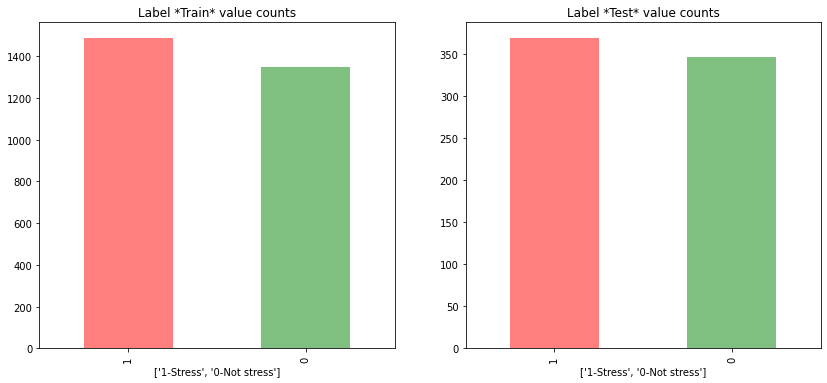

In [ ]:
f,axs = plt.subplots(1,2,figsize=(14,6))
df_train.label.value_counts().plot.bar(ax=axs[0],color=['r','g'],alpha=0.5)
df_test.label.value_counts().plot.bar(ax=axs[1],color=['r','g'],alpha=0.5)
axs[0].set_title('Label *Train* value counts')
axs[1].set_title('Label *Test* value counts')
axs[0].set_xlabel(['1-Stress','0-Not stress'])
axs[1].set_xlabel(['1-Stress','0-Not stress'])
plt.show()

In [ ]:
trn_cnts = df_train.label.value_counts()
tst_cnts = df_test.label.value_counts()
'{:.1f}% posts are labelled as stressed'.format((trn_cnts[1] + tst_cnts[1]) / (trn_cnts[0] + tst_cnts[0] + trn_cnts[1] + tst_cnts[1])*100)


'52.3% posts are labelled as stressed'

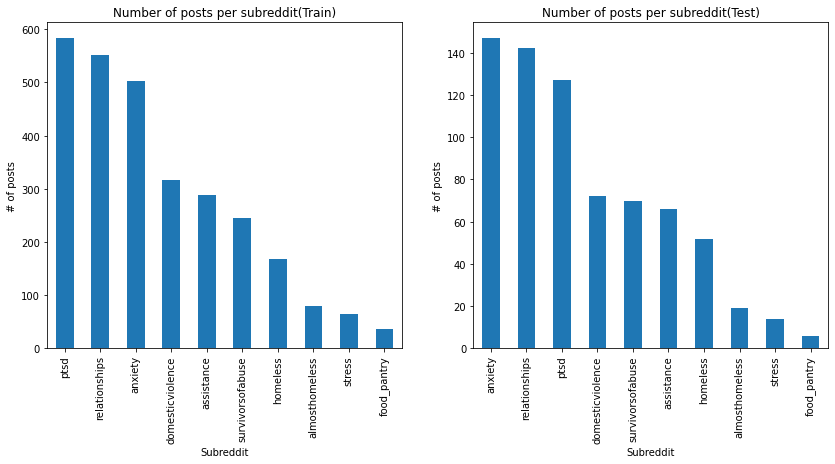

In [ ]:
f,axs = plt.subplots(1,2,figsize=(14,6))
df_train.subreddit.value_counts().plot.bar(ax=axs[0])
df_test.subreddit.value_counts().plot.bar(ax=axs[1])
axs[0].set_title('Number of posts per subreddit(Train)')
axs[1].set_title('Number of posts per subreddit(Test)')
axs[0].set_xlabel('Subreddit')
axs[1].set_xlabel('Subreddit')
axs[0].set_ylabel('# of posts')
axs[1].set_ylabel('# of posts')
plt.show()

## Prior Gender ratio

There seems to be a ratio of 1:4 (25% texts are cetegorized as being posted by females) of texts posted by females based on the dataset "lex_liwc_female" aמd "lex_liwc_male" features.
We noticed, however, that in online publications discussing the reported demographic statistics in Reddit posts, the ratio is closer to 2:3 (~40% women)

- "Female" = 1
- "Male" = 0

In [ ]:
from numpy.random import choice
#pick female or male by the prior assumption of .40/.60
choice(2,10,p=[0.4,0.6])

array([1, 1, 0, 1, 0, 1, 1, 0, 1, 1])

In [ ]:
df_gender_trn = df_train.copy()
df_gender_tst = df_test.copy()

In [ ]:
df_gender_trn['Female'] = np.where(df_gender_trn.lex_liwc_female>df_gender_trn.lex_liwc_male,1,0)
df_gender_tst['Female'] = np.where(df_gender_tst.lex_liwc_female>df_gender_tst.lex_liwc_male,1,0)

In [ ]:
print('Trn:\n',df_gender_trn.Female.value_counts(),'\nTst:\n',df_gender_tst.Female.value_counts())

Trn:
 0    2127
1     711
Name: Female, dtype: int64 
Tst:
 0    533
1    182
Name: Female, dtype: int64


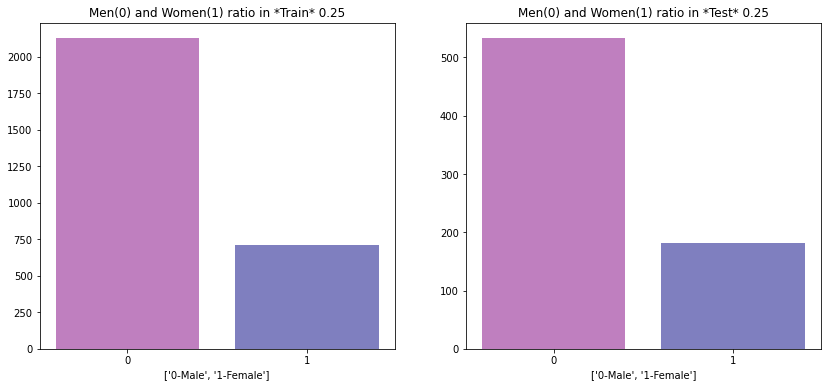

In [ ]:
f,axs = plt.subplots(1,2,figsize=(14,6))#,sharey=True)
trn=df_gender_trn.Female.value_counts()
male_trn = trn[0]
female_trn = trn[1]
female_pct_trn = female_trn/(male_trn+female_trn)
tst=df_gender_tst.Female.value_counts()
male_tst = tst[0]
female_tst = tst[1]
female_pct_tst = female_tst/(male_tst+female_tst)

axs[0].bar([0,1],[male_trn,female_trn],color=['purple','navy'],alpha=0.5)
axs[1].bar([0,1],[male_tst,female_tst],color=['purple','navy'],alpha=0.5)
axs[0].set_title('Men(0) and Women(1) ratio in *Train* 1 to {:.2f}'.format(female_pct_trn))
axs[1].set_title('Men(0) and Women(1) ratio in *Test* 1 to {:.2f}'.format(female_pct_tst))
axs[0].set_xlabel(['0-Male','1-Female'])
axs[1].set_xlabel(['0-Male','1-Female'])
axs[0].set_xticks([0,1])
axs[1].set_xticks([0,1])
plt.show()

## Posts Text lengths

The paper reported the average length around 100 which matches the average of 106 we see here (for labelled instances only)

In [ ]:
# find the maximum snetence length after tokenizer
bert_tok = transformers.BertTokenizer.from_pretrained('bert-base-uncased')

def find_max_lengths(tok,texts,percent,caption):
  max_sent_length = 0
  max_sent_length_list = []

  for sent in tqdm(texts):
      tokens= tok.tokenize(sent)
      ids = tok.convert_tokens_to_ids(tokens)
      input_len = len(tokens)
      input_len2 = len(ids)
      assert(input_len==input_len2)
      max_sent_length_list.append(input_len)

  max_sent_length = int(np.percentile(max_sent_length_list,percent))+1
  avg_sent_length = int(np.mean(max_sent_length_list))+1
  print(caption + ': {}th percentile of input length<={}'.format(percent,max_sent_length))
  print(caption + ': Average sentence length={}'.format(avg_sent_length))
  return max_sent_length,max_sent_length_list

# After trying with large values 500, 99.9=327 and others, we finally decided to
#take a "max len" of more or less +/-(2) standards devitations from the mean length
PERCENT=99.9 #60. best so far
max_length,trn_len_list = find_max_lengths(bert_tok,df_train['text'].values,PERCENT,caption='Train')
print ("Train Max input length after tokenization {}".format(max_length))


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

  0%|          | 0/2838 [00:00<?, ?it/s]

Train: 99.9th percentile of input length<=333
Train: Average sentence length=106
Train Max input length after tokenization 333


In [ ]:
_,tst_len_list = find_max_lengths(bert_tok,df_test['text'].values,PERCENT,caption='Test')

  0%|          | 0/715 [00:00<?, ?it/s]

Test: 99.9th percentile of input length<=282
Test: Average sentence length=105


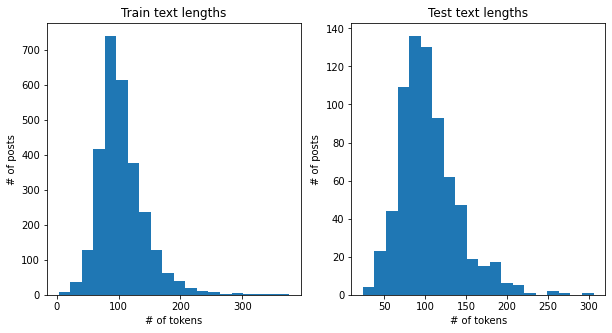

In [ ]:
f,ax = plt.subplots(1,2,figsize=(10,5))
plt.title('Posts text lengths (# of token)')
ax[0].hist(trn_len_list,bins=20)
ax[0].set_title('Train text lengths')
ax[0].set_xlabel('# of tokens')
ax[0].set_ylabel('# of posts')
ax[1].hist(tst_len_list,bins=20)
ax[1].set_title('Test text lengths')
ax[1].set_xlabel('# of tokens')
ax[1].set_ylabel('# of posts')
plt.show()

In [ ]:
#adding feature of text length 
df_train['text_length']=trn_len_list
df_test['text_length']=tst_len_list

## Feature Selection 

- Taking only features with a high confidence (4/5 human annotators agreement)
- Analyzing the correlation of features to the label, $Pearson \ge 0.4$ 

In [ ]:
df_train = df_train.drop(['post_id', 'sentence_range', 'id'], axis = 1)
df_test = df_test.drop(['post_id', 'sentence_range', 'id'], axis = 1)

In [ ]:
#Taking only instances with 80% agreement or more (confidence >=0.8)
print(len(df_train),len(df_test))
df_train = df_train[df_train['confidence']>=0.8]
df_test = df_test[df_test['confidence']>=0.8]
print(len(df_train),len(df_test))

2838 715
1852 445


In [ ]:
df = pd.concat([df_train,df_test],axis=0,ignore_index=True)
df = df.sample(frac = 1).reset_index(drop = True)
df.head(3)

,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_length
0,relationships,**tl;dr: My BF has a dirty house. Never cleans...,1,0.857143,1.516999e+09,10,-2.693947,36,9.47,20.24,...,1.125,1.0,1.64666,1.58571,1.81327,0.66,83,-0.074342,-0.300000,56
1,anxiety,"I started a new job last Tuesday, and I have h...",1,1.000000,1.503966e+09,2,3.325952,119,11.97,1.21,...,1.125,1.0,1.70180,1.54237,1.85991,1.00,4,5.322381,-0.032361,145
2,assistance,"I'm not competent to deal with life, despite b...",1,1.000000,1.483482e+09,20,4.428108,68,22.92,1.00,...,1.000,1.0,1.72244,1.39667,1.89150,0.77,12,6.606324,-0.141667,87


In [ ]:
#One hot encoding for the 'subreddit' column
le = LabelEncoder()
df['subreddit'] = le.fit_transform(df['subreddit'])


In [ ]:
df.head(2)

,subreddit,text,label,confidence,social_timestamp,social_karma,syntax_ari,lex_liwc_WC,lex_liwc_Analytic,lex_liwc_Clout,...,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment,text_length
0,7,**tl;dr: My BF has a dirty house. Never cleans...,1,0.857143,1.516999e+09,10,-2.693947,36,9.47,20.24,...,1.125,1.0,1.64666,1.58571,1.81327,0.66,83,-0.074342,-0.300000,56
1,1,"I started a new job last Tuesday, and I have h...",1,1.000000,1.503966e+09,2,3.325952,119,11.97,1.21,...,1.125,1.0,1.70180,1.54237,1.85991,1.00,4,5.322381,-0.032361,145


## Paper reported best score when:
- Confidence >=0.8 (4/5) 
- Correlation >= 0.4

## Feature Selection

In the paper they reported the best results with only the features that have  **$\ge 0.40$** Pearson correlation to the label

In [ ]:
most_correlated = df.corr().abs()['label'].sort_values(ascending = False)
#Taking only highest correlated features (paper's report |r|>=0.4)
most_correlated = most_correlated[:6]
most_correlated

label              1.000000
lex_liwc_Tone      0.567659
lex_liwc_Clout     0.506182
lex_liwc_negemo    0.506085
lex_liwc_i         0.491079
sentiment          0.390355
Name: label, dtype: float64

# Preprocessing

2 Tokenizers compared:
BertTokenizer and Bert using  Word2Vec vocabulary (Paper used it for best model)

In [ ]:
def clear_cache():
  import gc
  gc.collect()

In [ ]:
# Generate embedding vocabulary and save as local file 
def make_vocab_from_wv(wv, folder=None, special_tokens=None):
    # if folder is not None:
    #     if not os.path.exists(folder):
    #         os.mkdir(folder)

    words = wv.index2word
    if special_tokens is not None:
        to_add = []
        for special_token in special_tokens:
            if special_token not in words:
                to_add.append(special_token)
        words = to_add + words
                
    with open(os.path.join(folder, VOCAB_FILE), 'w') as f:
        for word in words:
            f.write(f'{word}\n') 

# run the function and make vocab on training data
if(os.path.exists(VOCAB_FILE)):
  print('Using local vocab file:',VOCAB_FILE)
else:
  # Download and load the word2vec embedding - based on the paper best model
  # This was done once and saved vocab in '
  word2vec = downloader.load('word2vec-google-news-300')
  make_vocab_from_wv(word2vec, 
                   './', 
                   special_tokens=['[PAD]', '[UNK]'])

Using local vocab file: dreaddit_vocab.txt


In [ ]:
clear_cache()
w2v_tok = transformers.BertTokenizer(VOCAB_FILE)

In [ ]:
#creating a function
def tokenize(tokenizer, texts):
    features = []
    for txt in tqdm(texts, desc = 'Tokenizing texts...'):
        tokens = tokenizer.tokenize(txt)
        ids = tokenizer.convert_tokens_to_ids(tokens)
        features.append(ids)
    return features

In [ ]:
#convert all column names to str
df.columns = df.columns.astype(str)

# Part 1 - Reproducing the Anchor paper results

In [ ]:
# [:15] works well f1 76.5 but with all features we get f1: 77.4
# features = ['text']+list(most_correlated[:60].index)
features = ['text']+list(most_correlated.index)


In [ ]:
#Selecting the features that are the most correlated with the label
# X,y = df[['text', 'lex_liwc_Tone', 'lex_liwc_negemo', 'lex_liwc_Clout','lex_liwc_i', 'sentiment' ]], df['label']
X,y = df[features], df['label']
# We tried 2 different tokenizer embeddings (Bert and Word2vec)
# bert_features = tokenize(bert_tok, X['text'])
bert_features = tokenize(w2v_tok, X['text'])

Tokenizing texts...:   0%|          | 0/2297 [00:00<?, ?it/s]

In [ ]:
#padding sequences to max len 
bert_trg = sequence.pad_sequences(bert_features, maxlen = max_length)

In [ ]:
#creating the training dataframe for the classic ML models out of the 
# using the most correlated features (correlated with the label)

X = pd.DataFrame(bert_trg)
#convert all column names to str
X.columns = X.columns.astype(str)
ftrs = {}
for f in features:
  if(f in['text','label']):
    continue
  ftrs[f]=df[f].values
X = X.assign(**ftrs)  


## Classic ML Models for stress classification

Using BERT Tokenizer

In [ ]:
def get_models():
    
    models = dict()
    #The “saga” solver is a variant of “sag” that also supports the non-smooth penalty="l1".
    # This is therefore the solver of choice for sparse multinomial logistic regression.
    # Setting a high C value is like "no regularization"
    #0.779
    models['LogReg'] = make_pipeline(StandardScaler(),LogisticRegression(solver = 'saga',
                                                                         C = 0.0008))
    # Paper's best config
    # models['LogReg2'] = make_pipeline(StandardScaler(),LogisticRegression(max_iter=1200,
    #                                                                       penalty='l2',
    #                                                                      C = 10))    
    models['MNNBayes'] = make_pipeline(MinMaxScaler(), MultinomialNB())
    models['SVM'] = make_pipeline(StandardScaler(),SVC())
    models['GBM'] = GradientBoostingClassifier(n_estimators = 10)
    models['ADAboost'] = AdaBoostClassifier(n_estimators= 12)
    models['XGBoost'] = XGBClassifier(n_estimators = 11, max_depth = 1)
    models['Dtree'] = DecisionTreeClassifier(max_depth = 1)
    models['Perceptron'] = make_pipeline(StandardScaler(),Perceptron())
    models['RandomF'] = RandomForestClassifier(n_estimators = 10)
    models['KNN'] = make_pipeline(StandardScaler(),KNeighborsClassifier())
    
    return models

## 5-fold Stratified cross validation for selected models

In [ ]:
# evaluate a given model using cross-validation 
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=SEED) #was 5
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

In [ ]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
best_score = 0
best_model = None
for name, model in models.items():
	print('Evaluating model:',name)
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	f1_mean=scores.mean()
	if(f1_mean>best_score):
		best_model = model
		best_name = name
		best_score = f1_mean
	print('>%s F1 Mean:%.3f STD:(%.3f)' % (name, scores.mean(), std(scores)))


Evaluating model: LogReg
>LogReg F1 Mean:0.829 STD:(0.016)
Evaluating model: MNNBayes
>MNNBayes F1 Mean:0.813 STD:(0.024)
Evaluating model: SVM
>SVM F1 Mean:0.811 STD:(0.019)
Evaluating model: GBM
>GBM F1 Mean:0.816 STD:(0.024)
Evaluating model: ADAboost
>ADAboost F1 Mean:0.815 STD:(0.022)
Evaluating model: XGBoost
>XGBoost F1 Mean:0.810 STD:(0.026)
Evaluating model: Dtree
>Dtree F1 Mean:0.798 STD:(0.028)
Evaluating model: Perceptron
>Perceptron F1 Mean:0.740 STD:(0.024)
Evaluating model: RandomF
>RandomF F1 Mean:0.759 STD:(0.032)
Evaluating model: KNN
>KNN F1 Mean:0.754 STD:(0.019)


In [ ]:
print('Best classic ML model:{} with F1:{:.3f}'.format(best_name,best_score))

Best classic ML model:LogReg with F1:0.829


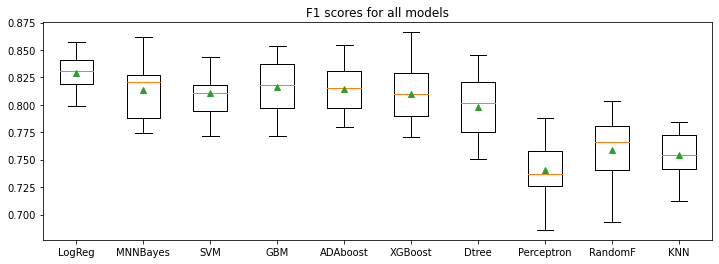

In [ ]:
# plot model performance comparison
f,ax = plt.subplots(1,1,figsize=(12,4))
plt.boxplot(results, labels=names, showmeans=True,showbox=True,showcaps=True)

plt.title('F1 scores for all models')
plt.show()

## Bert for stress classification

Fine tuning the model for 3 epochs shows great results

In [ ]:
!rm -rf cache_dir
!rm -rf outputs
!rm -rf runs

In [ ]:
logging.basicConfig(level=logging.ERROR)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.ERROR)

# Train or Inference mode
TRAINED_MODEL='bert_dreaddit_model.zip'
!cp -nf {DRIVE_PATH}/last_model/{TRAINED_MODEL} .
INFERENCE_MODE = os.path.isfile(TRAINED_MODEL)
if(INFERENCE_MODE):
  print('Inference mode, loading best model...')
  !unzip -q -n {TRAINED_MODEL}
  # Create a ClassificationModel
  model = ClassificationModel(
      "bert", "bert-base-uncased", #f1=80 Paper's BEST
      # "roberta", "outputs/best_model", #f1=80 BEST
      use_cuda=torch.cuda.is_available()
  )
  print('Best model loaded.')
else:
  print('Training mode')
  # Optional model configuration
  model_args = ClassificationArgs(num_train_epochs=3,
                                  overwrite_output_dir = True,
                                  # fp16=True,
                                  use_early_stopping = True,
                                  # max_seq_length=max_length,
                                  no_save = False,
                                  save_best_model=True,
                                  evaluate_during_training = True,
                                  evaluate_during_training_verbose=False,
                                  evaluate_during_training_silent=True,
                                  #paper's best params
                                  # num_train_epochs=3,
                                  # train_batch_size=128,
                                  # learning_rate=0.0005,
  )

  # Create a ClassificationModel
  model = ClassificationModel(
      # "roberta", "roberta-base", #f1=80 BEST on full
      "bert", "bert-base-uncased",tokenizer_type=w2v_tok,#f1=79 #Paper's best
      # "bert", "bert-base-cased",#f1=79
      # "roberta", "roberta-large", #f1=77
      # "distilbert", "bert-base-uncased", #f1=71
      # "albert","bert-base-uncased", #bad
      # "electra", "bert-base-uncased", #bad...
      args=model_args,
      use_cuda=torch.cuda.is_available(),
  )

  # Train the model
  model.train_model(df_train[['text','label']],eval_df=df_test[['text','label']])

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(df_test[['text','label']])


cp: cannot stat '/content/drive/MyDrive/2022/S2/3603_Advanced_MachineLearning/notebooks/final_proj//last_model/bert_dreaddit_model.zip': No such file or directory
Training mode


  0%|          | 0/1852 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/232 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/445 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_title(title)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    

In [ ]:
y_true_trn = df_train['label'].values
print('Train classification report')
y_pred_trn, _ = model.predict(list(df_train['text']))


Train scores:


  0%|          | 0/1852 [00:00<?, ?it/s]

  0%|          | 0/232 [00:00<?, ?it/s]

In [ ]:
print(classification_report(y_true_trn, y_pred_trn))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       849
           1       0.99      0.99      0.99      1003

    accuracy                           0.99      1852
   macro avg       0.99      0.99      0.99      1852
weighted avg       0.99      0.99      0.99      1852



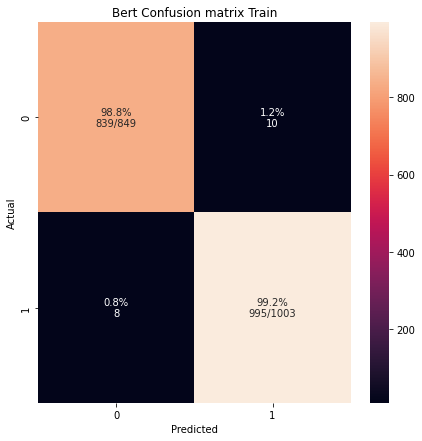

In [ ]:
# Showing Confusion Matrix for ST Bert model
plot_cm(y_true_trn,y_pred_trn, 'Bert Confusion matrix Train', figsize=(7,7))

In [ ]:
y_true_tst = df_test['label'].values
print('Test classification report')
y_pred_tst, _ = model.predict(list(df_test['text']))

Test scores:


  0%|          | 0/445 [00:00<?, ?it/s]

  0%|          | 0/56 [00:00<?, ?it/s]

In [ ]:
print(classification_report(y_true_tst, y_pred_tst))
f1_bert = f1_score(y_true_tst, y_pred_tst,average='weighted')

              precision    recall  f1-score   support

           0       0.95      0.81      0.87       201
           1       0.86      0.97      0.91       244

    accuracy                           0.89       445
   macro avg       0.91      0.89      0.89       445
weighted avg       0.90      0.89      0.89       445



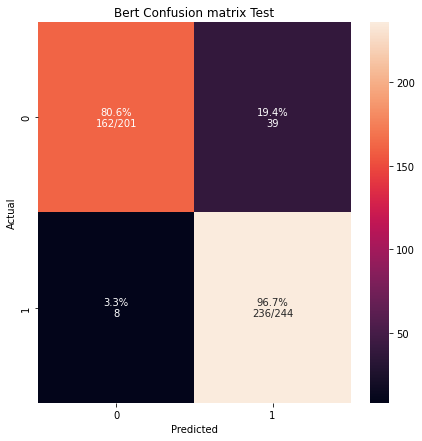

In [ ]:
# Showing Confusion Matrix for ST Bert model
plot_cm(y_true_tst,y_pred_tst, 'Bert Confusion matrix Test', figsize=(7,7))

In [ ]:
all_models = ['BERT-base'] + names
all_results = [f1_bert] + [np.mean(r) for r in results]

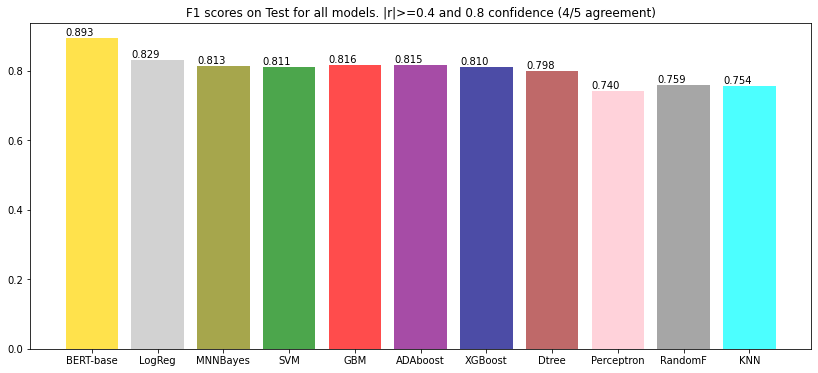

In [ ]:
# plot model performance comparison
f,ax = plt.subplots(1,1,figsize=(14,6))
cmap = ['gold','silver','olive','green','red','purple','navy','brown','pink','grey','cyan']
plt.bar(all_models,all_results,color=cmap,alpha=0.7)
for j,p in enumerate(ax.patches):
  ax.annotate('{:.3f}'.format(p.get_height()), (p.get_x(), p.get_height() * 1.01))

plt.title('F1 scores on Test for all models. |r|>=0.4 and 0.8 confidence (4/5 agreement)')
# plt.title('F1 scores on Test for all models (Full dataset)')
plt.show()

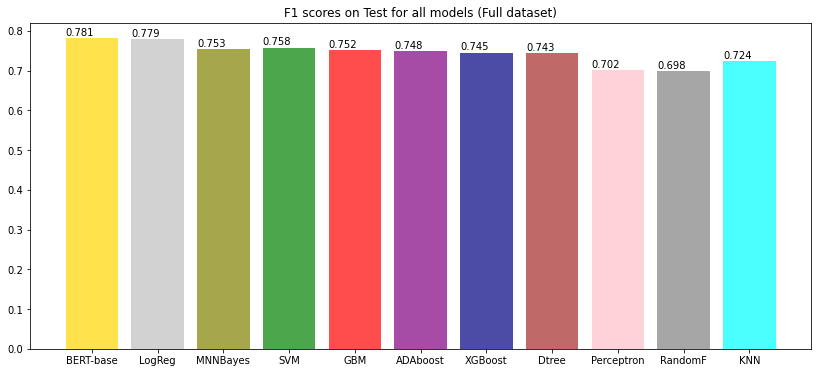

In [ ]:
BACKUP=False
if(BACKUP):
  !zip {TRAINED_MODEL} outputs/best_model/*.*
  !cp -nf {TRAINED_MODEL} {DRIVE_PATH}/last_model/

# References

*  [stress-analysis-in-social-media](https://www.kaggle.com/datasets/ruchi798/) 

<br>

**Thank you**

